# 2. Analysis

## Setup

Run the data_cleaning notebook tho have access to all its contents in this shell

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, average_precision_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

sp = spacy.load('en_core_web_sm')
plt.rcParams['figure.figsize'] = [10, 7]

### Import dataset

In [2]:
data = pd.read_csv("../data/extremely_clean_dataset.csv") 

# Keep the first 100 elements to reduce the load on cpu
#data = data[:10]
data.head()

,review,sentiment
0,reviewer mention watch episode hook right exac...,positive
1,wonderful little production technique very una...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically family little boy think zombie close...,negative
4,petter love time money visually stunning film ...,positive


## 2.1 EDA

In [3]:
data.describe()

,review,sentiment
count,50000,50000
unique,49569,2
top,love variety not solely cook great very captiv...,positive
freq,5,25000


In [4]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [5]:
base_rate = max(data['sentiment'].value_counts()) / data.shape[0]
print("Base rate: {}".format(base_rate))

Base rate: 0.5


## 2.2 Models

#### Splitting the dataset into training and test sets

In [6]:
X = data['review'] # the features we want to analyze, we can play with others too
y = data['sentiment'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

#### Tokenizer

In [7]:
nlp = spacy.lang.en.English()

def tokenize_review(this_review):
    return [token.text for token in nlp(this_review)]

### 2.2.1 Logistic Model

In [8]:
# Notes: - saga is better than lbfgs for large datasets
#        - at default max_iter (1000) the model doesn't converge, 2000 works
classifier = LogisticRegression(solver="saga", max_iter=2000)

count_vector = CountVectorizer(tokenizer = tokenize_review, ngram_range = (1,2))

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', count_vector), ('classifier', classifier)])

# Fit Model
pipe.fit(X_train,y_train)

pipe.score(X_test, y_test)

0.8971

### Strongest Coefficients

In [9]:
def get_interesting_features(features):
    interesting_coefs = []
    for best_positive in sorted(features.items(), key=lambda x: x[1], reverse=True)[:5]:
        interesting_coefs.append(best_positive)

    for best_negative in sorted(features.items(), key=lambda x: x[1])[:5]:
        interesting_coefs.append(best_negative)
    return interesting_coefs

In [10]:
def graph_interesting_features(interesting_features):
    sorted_by_coef = sorted(interesting_features, key=lambda tup: tup[1], reverse=True)

    feature = [elem[0] for elem in sorted_by_coef]
    coef = [elem[1] for elem in sorted_by_coef]

    plt.bar(feature, coef)
    plt.xticks(feature, fontsize=12)
    plt.xticks(rotation=30)
    plt.show()

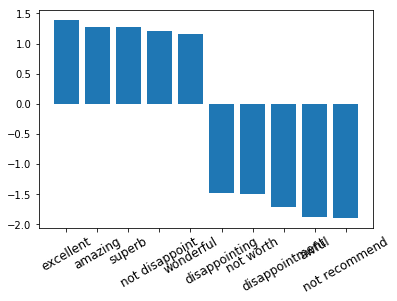

In [11]:
model_features = {
    word: coef for word, coef in zip(
        count_vector.get_feature_names(), classifier.coef_[0]
    )
}

interesting_features = get_interesting_features(model_features)
graph_interesting_features(interesting_features)

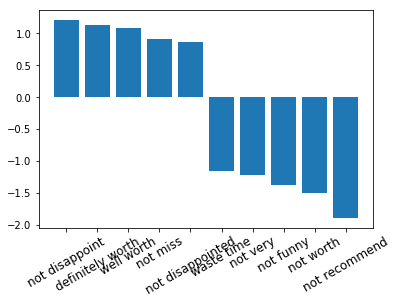

In [12]:
two_gram_features = {key: model_features[key] for key in model_features.keys() if len(key.split(' ')) == 2}
intersting_features = get_interesting_features(two_gram_features)
graph_interesting_features(intersting_features)

#### Results

In [14]:
#test set metrics
from sklearn.metrics import classification_report
target_pred = pipe.predict(X_test)
print(classification_report(y_test, target_pred))

              precision    recall  f1-score   support

    negative       0.90      0.89      0.90      4996
    positive       0.89      0.90      0.90      5004

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



#### Confusion matrix

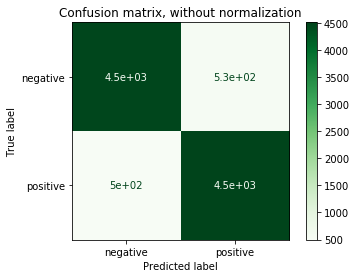

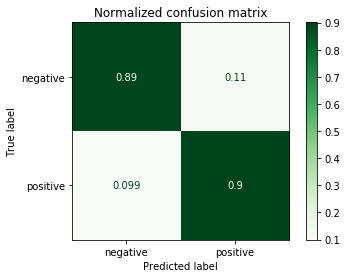

In [15]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(pipe, X_test, y_test, cmap=plt.cm.Greens, normalize=normalize)
    disp.ax_.set_title(title)

#### Precision Recall Curve


Average precision-recall score: 0.96


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.96')

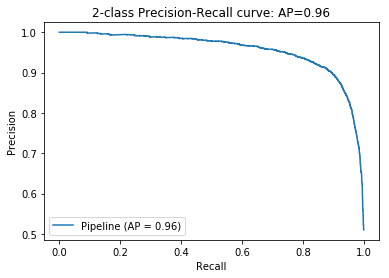

In [16]:
y_score = pipe.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score, pos_label="positive")

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(pipe, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

### 2.2.2 Decision Trees

In [17]:
X = count_vector.fit_transform(data['review'])
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

In [18]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=10)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [19]:
tree.score(X_test,y_test)

0.7379

In [20]:
tree.get_depth()

10

#### Tuning the depth of the tree

In [21]:
#scores = []
#for d in range(1, 21):
#    test_tree = DecisionTreeClassifier(criterion='entropy', max_depth=d)
#    test_tree.fit(X_train, y_train)
#    scores.append(test_tree.score(X_test, y_test))

In [22]:
#plt.plot(scores)
#plt.ylabel('accuracy', fontsize=15)
#plt.xlabel('depth', fontsize=15)

[Text(198.1759765625, 207.55636363636364, 'X[119891] <= 0.5\nentropy = 1.0\nsamples = 40000\nvalue = [20004, 19996]'),
 Text(122.6376953125, 187.7890909090909, 'X[1940279] <= 0.5\nentropy = 0.959\nsamples = 27837\nvalue = [10636, 17201]'),
 Text(86.400390625, 168.0218181818182, 'X[763805] <= 0.5\nentropy = 0.938\nsamples = 26334\nvalue = [9345, 16989]'),
 Text(50.88359375, 148.25454545454545, 'X[114582] <= 0.5\nentropy = 0.979\nsamples = 18680\nvalue = [7740, 10940]'),
 Text(31.58125, 128.48727272727274, 'X[581678] <= 0.5\nentropy = 0.97\nsamples = 18035\nvalue = [7188, 10847]'),
 Text(20.925, 108.72, 'X[186159] <= 0.5\nentropy = 0.981\nsamples = 16670\nvalue = [7003, 9667]'),
 Text(12.4, 88.95272727272729, 'X[1038302] <= 0.5\nentropy = 0.973\nsamples = 15942\nvalue = [6445, 9497]'),
 Text(6.2, 69.18545454545455, 'X[1203679] <= 0.5\nentropy = 0.99\nsamples = 12388\nvalue = [5477, 6911]'),
 Text(3.1, 49.418181818181836, 'X[1781100] <= 0.5\nentropy = 0.981\nsamples = 11111\nvalue = [4651

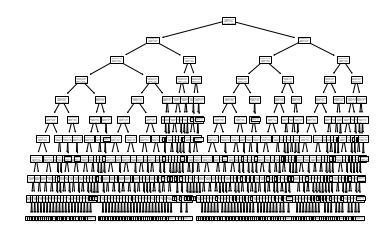

In [23]:
from sklearn.tree import plot_tree

plot_tree(tree)

In [24]:
#test set metrics
from sklearn.metrics import classification_report
target_pred = tree.predict(X_test)
print(classification_report(y_test, target_pred))

              precision    recall  f1-score   support

    negative       0.78      0.66      0.71      4996
    positive       0.71      0.82      0.76      5004

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



#### Confusion matrix

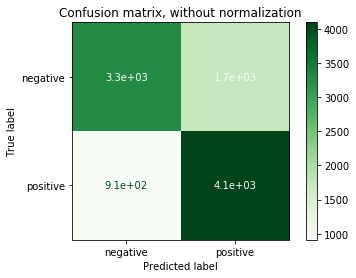

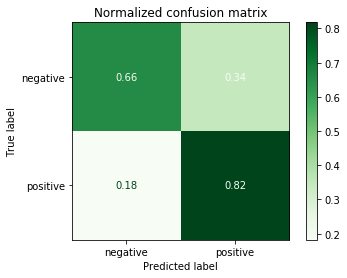

In [25]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Greens, normalize=normalize)
    disp.ax_.set_title(title)

###  2.2.3 KNN Classification

In [26]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [27]:
X = count_vector.fit_transform(data['review'])
y = data['sentiment']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

In [29]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [30]:
knn.score(X_test, y_test)

0.604

In [31]:
#test set metrics
from sklearn.metrics import classification_report
target_pred = knn.predict(X_test)
print(classification_report(y_test, target_pred))

              precision    recall  f1-score   support

    negative       0.58      0.74      0.65      4996
    positive       0.64      0.47      0.54      5004

    accuracy                           0.60     10000
   macro avg       0.61      0.60      0.60     10000
weighted avg       0.61      0.60      0.60     10000



#### Tuning the value of n

In [32]:
#scores = []
#for n in range(1, 21):
#    knn = KNeighborsClassifier(n_neighbors=n, weights='uniform')
#    knn.fit(X_train, y_train)
#    scores.append(knn.score(X_test, y_test))

In [33]:
#plt.plot(scores)
#plt.ylabel('accuracy', fontsize=15)
#plt.xlabel('N', fontsize=15)

#### Confusion matrix

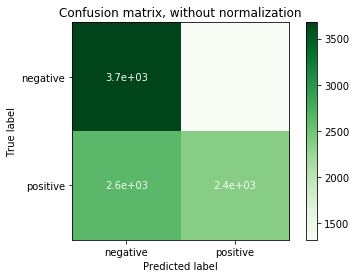

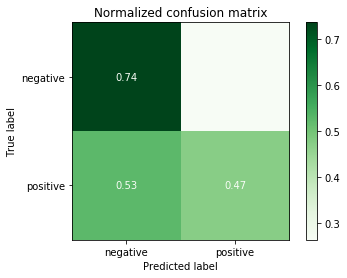

In [34]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Greens, normalize=normalize)
    disp.ax_.set_title(title)

# 2.3. Conclusion and Recommendation

From the analysis shown above we can see that the best performing method of classification of the reviews into binary class positive/negative is Logistic Regression method......